This notebook shows how to convert a [CartoonGAN model](https://github.com/SystemErrorWang/White-box-Cartoonization) to ONNX and how to run inference with it. It uses code from [this notebook](https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/CartoonGAN_TFLite.ipynb). 

## Setup the CartoonGAN repo

We're using a cloned version of the original repo (linked above) that has support for TF 2.x inference. 

In [1]:
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git
!pip install --upgrade tf_slim

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 63.41 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 7.7 MB/s 


## Imports

In [2]:
import sys

sys.path.append("./White-box-Cartoonization/test_code")

import matplotlib.pyplot as plt
import cartoonize
import os

from PIL import Image

In [3]:
# Directory where SavedModel is to be saved
!mkdir saved_model_dir

## Generate `SavedModel` artifact

In [4]:
# Comes with the GitHub repo
# These will be needed to instantiate the model
import network
import guided_filter

In [5]:
# We will be using TensorFlow session
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

In [6]:
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

model_path = "./White-box-Cartoonization/test_code/saved_models"

with tf.Session(config=config) as sess:
    # Create placeholder for the input
    input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name="input_photo")

    # Run the input placeholder through the generator, and then apply a
    # filter to process the generator output
    network_out = network.unet_generator(input_photo)
    final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
    final_out = tf.identity(
        final_out, name="final_output"
    )  # Create an identical filtering layer

    # The above process is basically needed to construct the computation graph for the
    # current session

    # Get the generator variables and restore the pre-trained checkpoints in the
    # current session
    all_vars = tf.trainable_variables()
    gene_vars = [var for var in all_vars if "generator" in var.name]
    saver = tf.train.Saver(var_list=gene_vars)
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint(model_path))

    # Export to SavedModel
    tf.saved_model.simple_save(
        sess,
        "/content/saved_model_dir",
        inputs={input_photo.name: input_photo},
        outputs={final_out.name: final_out},
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [7]:
!du -h saved_model_dir

5.7M	saved_model_dir/variables
5.8M	saved_model_dir


## Convert to ONNX

In [8]:
!pip install -q git+https://github.com/onnx/tensorflow-onnx
!pip install -q onnxruntime

     |████████████████████████████████| 13.1 MB 7.0 MB/s 
     |████████████████████████████████| 4.9 MB 8.5 MB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 


In [9]:
!python -m tf2onnx.convert --opset 11 --saved-model saved_model_dir --output cartoonizer.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-08-13 20:52:20,900 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-08-13 20:52:21,310 - INFO - Signatures found in model: [serving_default].
2022-08-13 20:52:21,310 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-08-13 20:52:21,310 - INFO - Output names: ['final_output:0']
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
This operation is not supported when eager execution is enabled.
2022-08-13 20:52:21,314 - WARNING - Issue encountered when serializing model_variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probabl

In [10]:
!ls -lh cartoonizer.onnx

-rw-r--r-- 1 root root 5.7M Aug 13 20:52 cartoonizer.onnx


## Perform inference and visualize

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import onnxruntime as ort

In [13]:
!wget -O image.jpg https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg

--2022-08-13 20:56:02--  https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111191 (109K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 108.58K  --.-KB/s    in 0.01s   

2022-08-13 20:56:02 (7.92 MB/s) - ‘image.jpg’ saved [111191/111191]



In [14]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720 * h / w), 720
        else:
            h, w = 720, int(720 * w / h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h // 8) * 8, (w // 8) * 8
    image = image[:h, :w, :]
    return image

In [15]:
# Prepare image for inference
image = cv2.imread("image.jpg")
image = resize_crop(image)
image = image.astype(np.float32) / 127.5 - 1
image = np.expand_dims(image, axis=0)
image.shape

(1, 440, 288, 3)

In [16]:
# Load the model
sess = ort.InferenceSession("cartoonizer.onnx")

In [19]:
# Perform inference
results = sess.run(None, {"input_photo:0": image})

In [22]:
output = (np.squeeze(results[0]) + 1.0) * 127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

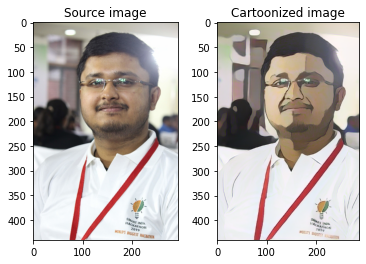

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(plt.imread("image.jpg"))
plt.title("Source image")
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("Cartoonized image")
plt.show()